<a href="https://colab.research.google.com/github/Fadwa62/DeepLearning/blob/main/PINN_heat.eqt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 0, Loss=1.23582e-01, alpha=0.5010
Epoch 500, Loss=6.92901e-03, alpha=0.2527
Epoch 1000, Loss=4.27224e-04, alpha=0.1861
Epoch 1500, Loss=1.33303e-04, alpha=0.1937
Epoch 2000, Loss=5.78717e-05, alpha=0.1962
Epoch 2500, Loss=3.97183e-05, alpha=0.1972
Epoch 3000, Loss=4.00051e-04, alpha=0.1976
Epoch 3500, Loss=2.28455e-05, alpha=0.1981
Epoch 4000, Loss=1.97596e-05, alpha=0.1983
Epoch 4500, Loss=1.79426e-05, alpha=0.1984


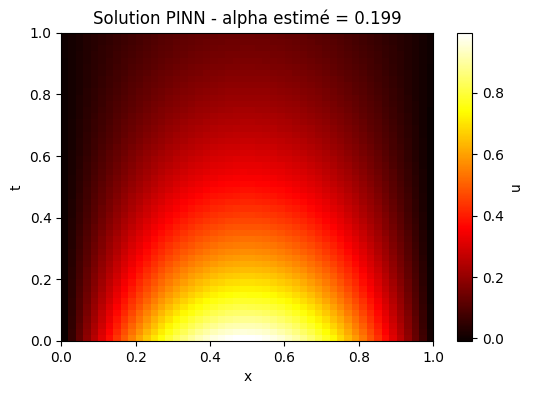

In [ ]:
!pip install torch numpy matplotlib scipy -q

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# -------------------------
# 1) Génération de données fictives (alpha=0.2)
# -------------------------
alpha_true = 0.2
nx, nt = 50, 50
x = np.linspace(0,1,nx)
t = np.linspace(0,1,nt)

# solution analytique connue pour cette CI: u0 = sin(pi*x)
# u(t,x) = exp(-alpha*pi^2*t)*sin(pi*x)
X, T = np.meshgrid(x,t)
U_true = np.exp(-alpha_true*(np.pi**2)*T)*np.sin(np.pi*X)

# on prend quelques points comme "données mesurées"
idx = np.random.choice(nx*nt, size=500, replace=False)
tx_data = np.stack([T.flatten()[idx], X.flatten()[idx]], axis=1)
u_data = U_true.flatten()[idx][:,None]

tx_data = torch.tensor(tx_data, dtype=torch.float32).to(device)
u_data = torch.tensor(u_data, dtype=torch.float32).to(device)

# -------------------------
# 2) Modèle PINN avec alpha appris
# -------------------------
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )
        # paramètre alpha inconnu
        self.alpha = nn.Parameter(torch.tensor(0.5))  # initial guess

    def forward(self, tx):
        return self.net(tx)

model = PINN().to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

# points collocation pour le résidu PDE
N_f = 2000
tx_f = torch.rand(N_f,2).to(device)

# -------------------------
# 3) Entraînement
# -------------------------
for epoch in range(5000):
    optim.zero_grad()

    # Résidu PDE
    tx_f_ = tx_f.clone().requires_grad_(True)
    u = model(tx_f_)
    grads = torch.autograd.grad(u, tx_f_, torch.ones_like(u), create_graph=True)[0]
    u_t = grads[:,0:1]
    u_x = grads[:,1:2]
    u_xx = torch.autograd.grad(u_x, tx_f_, torch.ones_like(u_x), create_graph=True)[0][:,1:2]
    f = u_t - model.alpha * u_xx
    loss_pde = torch.mean(f**2)

    # Erreur sur les données mesurées
    u_pred_data = model(tx_data)
    loss_data = torch.mean((u_pred_data - u_data)**2)

    loss = loss_pde + loss_data
    loss.backward()
    optim.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss={loss.item():.5e}, alpha={model.alpha.item():.4f}")

# -------------------------
# 4) Visualisation
# -------------------------
with torch.no_grad():
    TX = torch.tensor(np.stack([T.flatten(),X.flatten()],axis=1),dtype=torch.float32).to(device)
    U_pred = model(TX).cpu().numpy().reshape(nt,nx)

plt.figure(figsize=(6,4))
plt.imshow(U_pred, extent=[0,1,0,1], origin='lower', aspect='auto', cmap='hot')
plt.colorbar(label='u')
plt.xlabel('x'); plt.ylabel('t')
plt.title(f'Solution PINN - alpha estimé = {model.alpha.item():.3f}')
plt.show()
